In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

using StatsBase
using UnPack
# using DimensionalData
# includet("../../../scripts/dimdata_util.jl")

In [3]:
using GLMakie
using CairoMakie

# Setup

In [4]:
function clamp_for_log(xx)
    clamp.(xx, max(minimum(xx), eps()), Inf)
end
function make_hm_ax(args...; kwargs...)
    Axis(args...;
        # yticks=exticks,
        ylabel=L"\epsilon",
        xlabel=L"K",
        xscale=log10,
        kwargs...
    )
end

make_hm_ax (generic function with 1 method)

In [5]:
function make_quality_summary(f)
    display(countmap(f["retcodes"]))

    logKs = f["logKs"]
    ls = f["ls"]
    leak_xs = LeakageScale.ltox.(ls)

    ext_ls = extrema(ls)
    exticks = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], 7))
    
    fig = Figure(;
        size=(1000, 400)
    )

    ax1 = make_hm_ax(fig[1,1];
        yticks=exticks,
        title="Reached final time"
    )
    hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, f["final_T"];
        # colorscale=log10
    )
    Colorbar(fig[1,2], hm1)

    maxresids = map(zip(f["params"], f["final_states"])) do (ps, fs)
        maximum(abs, uninplace(smmicrmfunc!)(fs, ps))
    end;
    ax2 = make_hm_ax(fig[1,3];
        yticks=exticks,
        title="Maximal absolute residuals"
    )
    hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, clamp_for_log(maxresids);
        colorscale=log10
    )
    Colorbar(fig[1,4], hm2)

    fig
end

make_quality_summary (generic function with 1 method)

# Load data

## First v2 - base, ls include 0 and 1

In [17]:
f = jldopen("./v2main_highN0_base.jld2")
logKs = f["logKs"]
ls = f["ls"][2:end-1]
leak_xs = LeakageScale.ltox.(ls)
T = f["T"]
fss = f["final_states"][:,2:end-1]
fTs = f["final_T"][:,2:end-1]

@show countmap(f["retcodes"])
@show T
@show countmap(fTs);

countmap(f["retcodes"]) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)
T = 1.0e6
countmap(fTs) = Dict(1.0e6 => 2240)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 2400

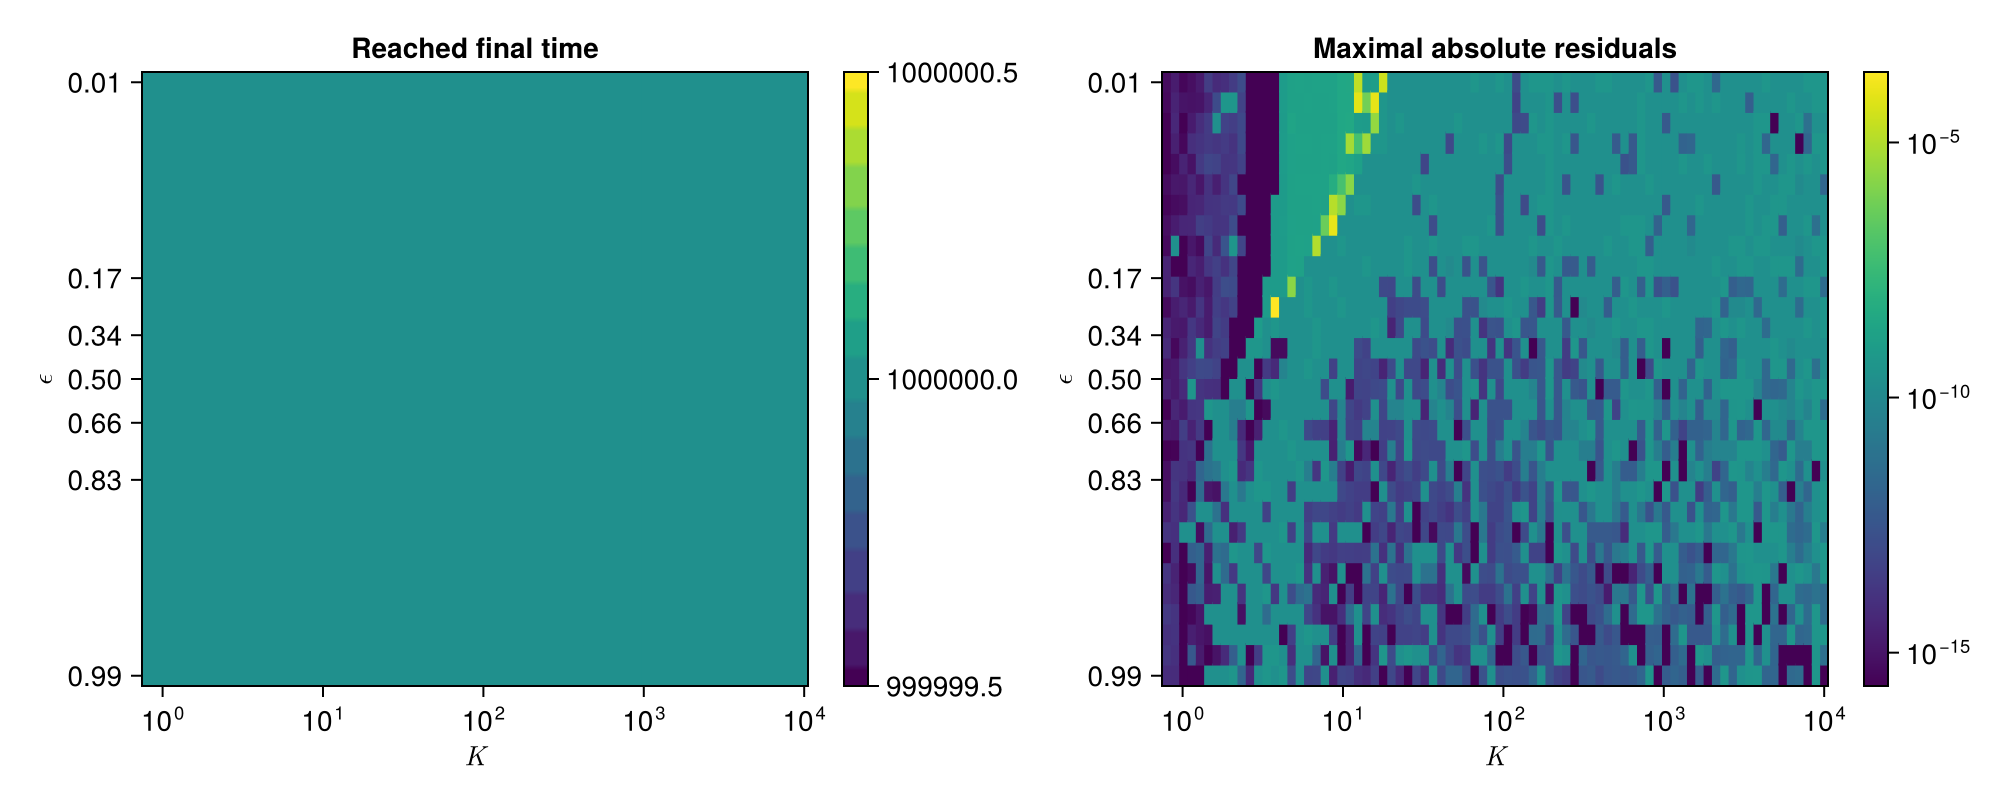

In [18]:
make_quality_summary(f)

## Second v2 - m=10, DR=0.1, logit ls

In [6]:
f = jldopen("./v2main_highN0_largem_lowDR.jld2")
logKs = f["logKs"]
ls = f["ls"]
leak_xs = LeakageScale.ltox.(ls)
T = f["T"]
fss = f["final_states"]
fTs = f["final_T"]

ext_ls = extrema(ls)
exticks = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], 7))

countmap(f["retcodes"])
# @show T
# @show countmap(fTs);

Dict{SciMLBase.ReturnCode.T, Int64} with 2 entries:
  Success => 2274
  MaxTime => 126

Dict{SciMLBase.ReturnCode.T, Int64} with 2 entries:
  Success => 2274
  MaxTime => 126

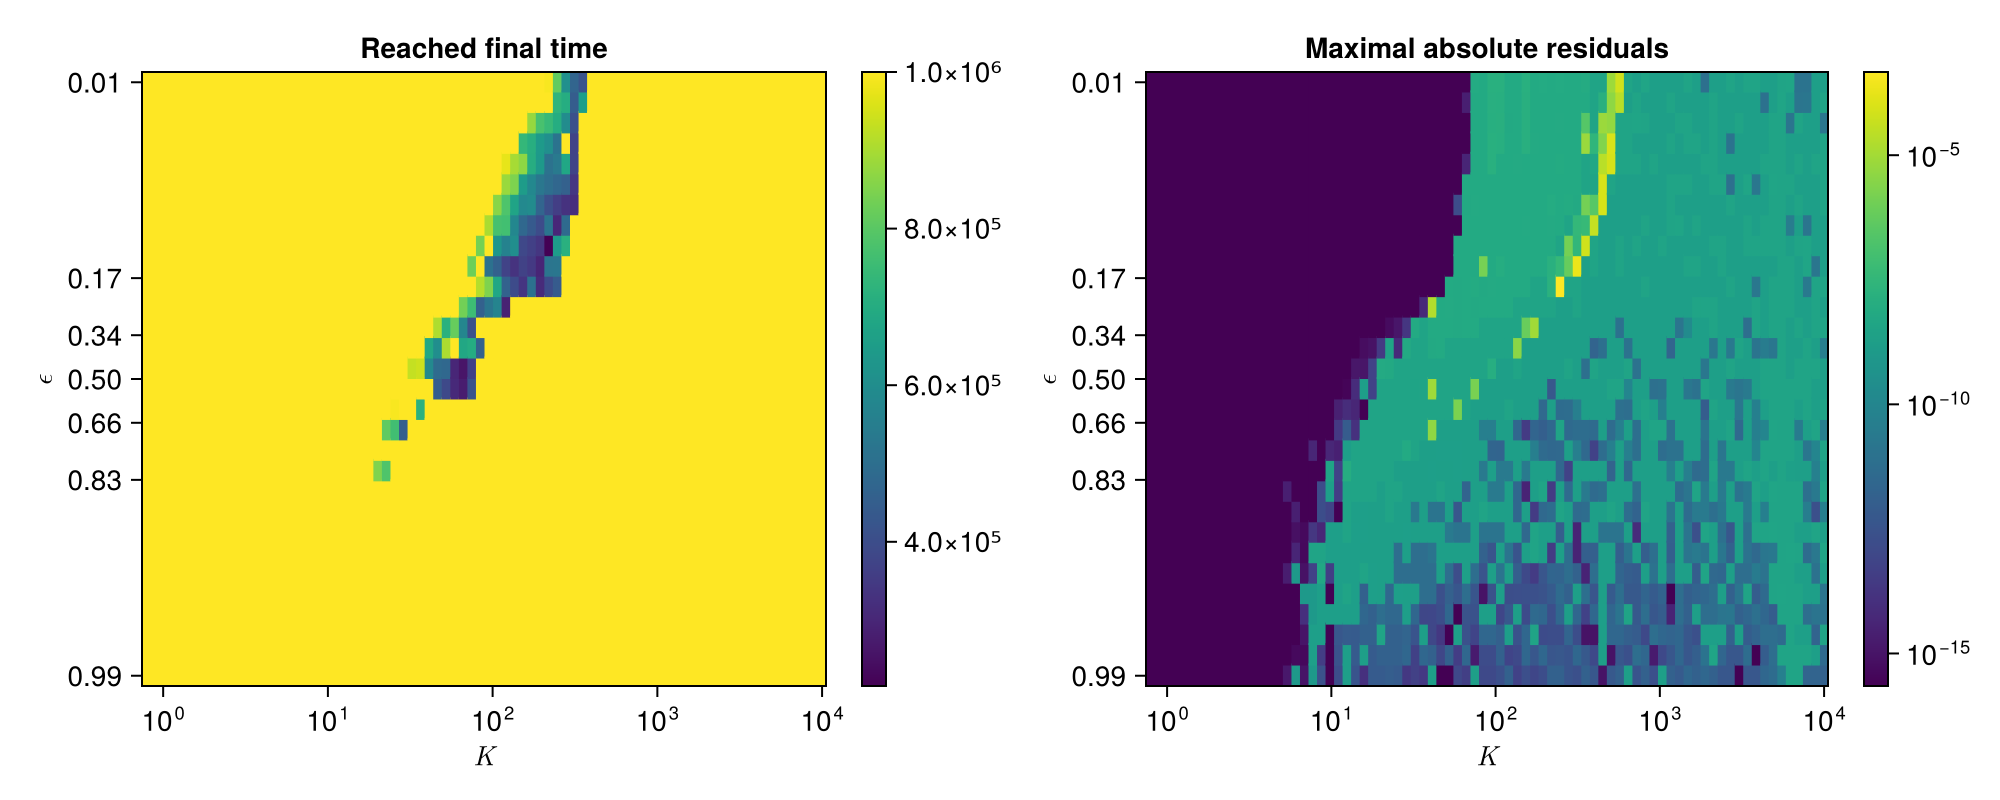

In [7]:
make_quality_summary(f)

### Some runs, in a particular region seem to be running into max time
however when inspecting them this does not seem to be particularly interesting, they look qualitatively similar to others and seem to be very close to steady states already

In [25]:
xx = DimArray(fss, (; logKs, ls));
yy = DimArray(fTs, (; logKs, ls));

yy[ii...] = 296735.2686574786


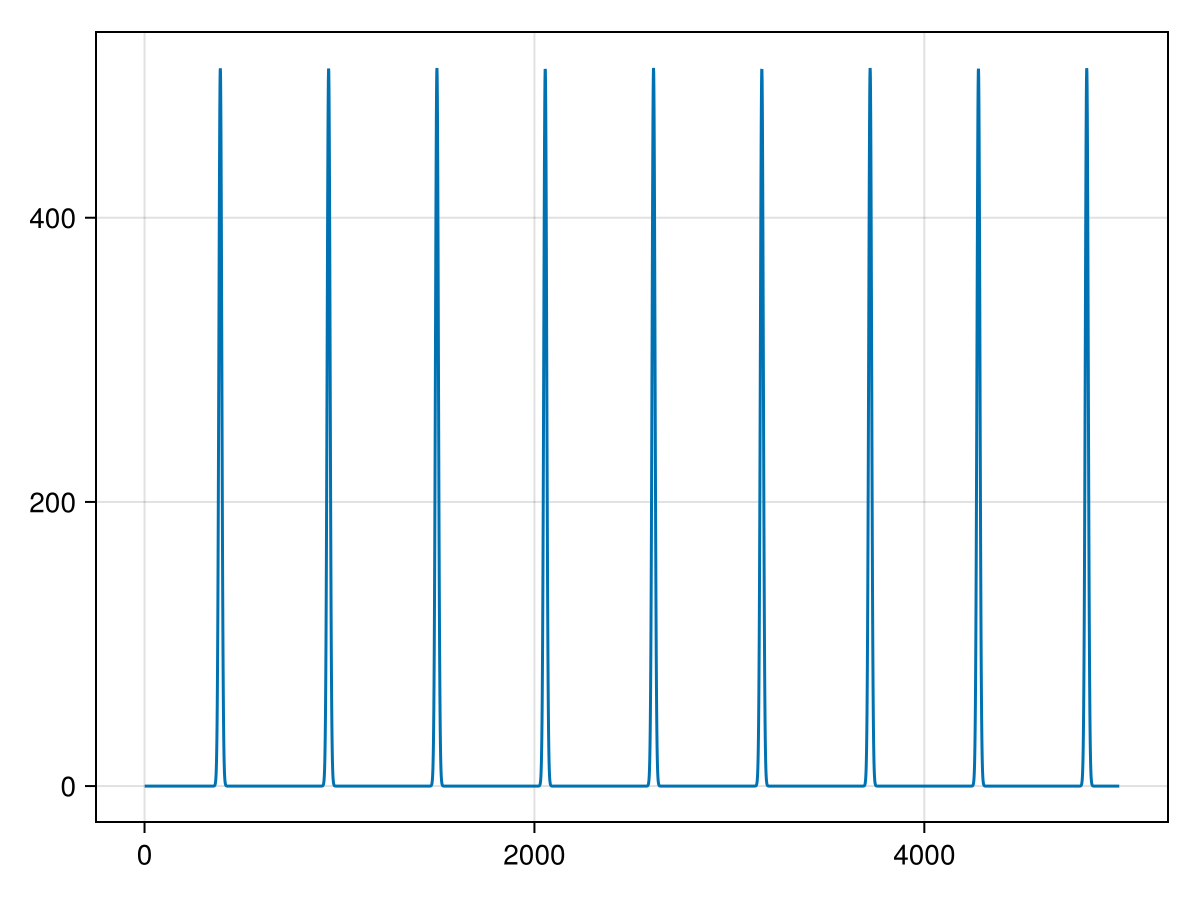

In [26]:
ii = (Near(2.3), Near(1-0.17))
@show yy[ii...]
lines(xx[ii...][1,:])

## Run no-space

In [89]:
@time nospace_results = run_Kl_nospace(f;
    ls=ls,
    maxtime=10,
    maxiters=1000000,
    tol=1000*eps()
)

nsfss = nospace_results.final_states
nsfTs = nospace_results.final_Ts

countmap(nospace_results.retcodes)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.567000 seconds (34.61 M allocations: 2.959 GiB)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 2400

### Debugging

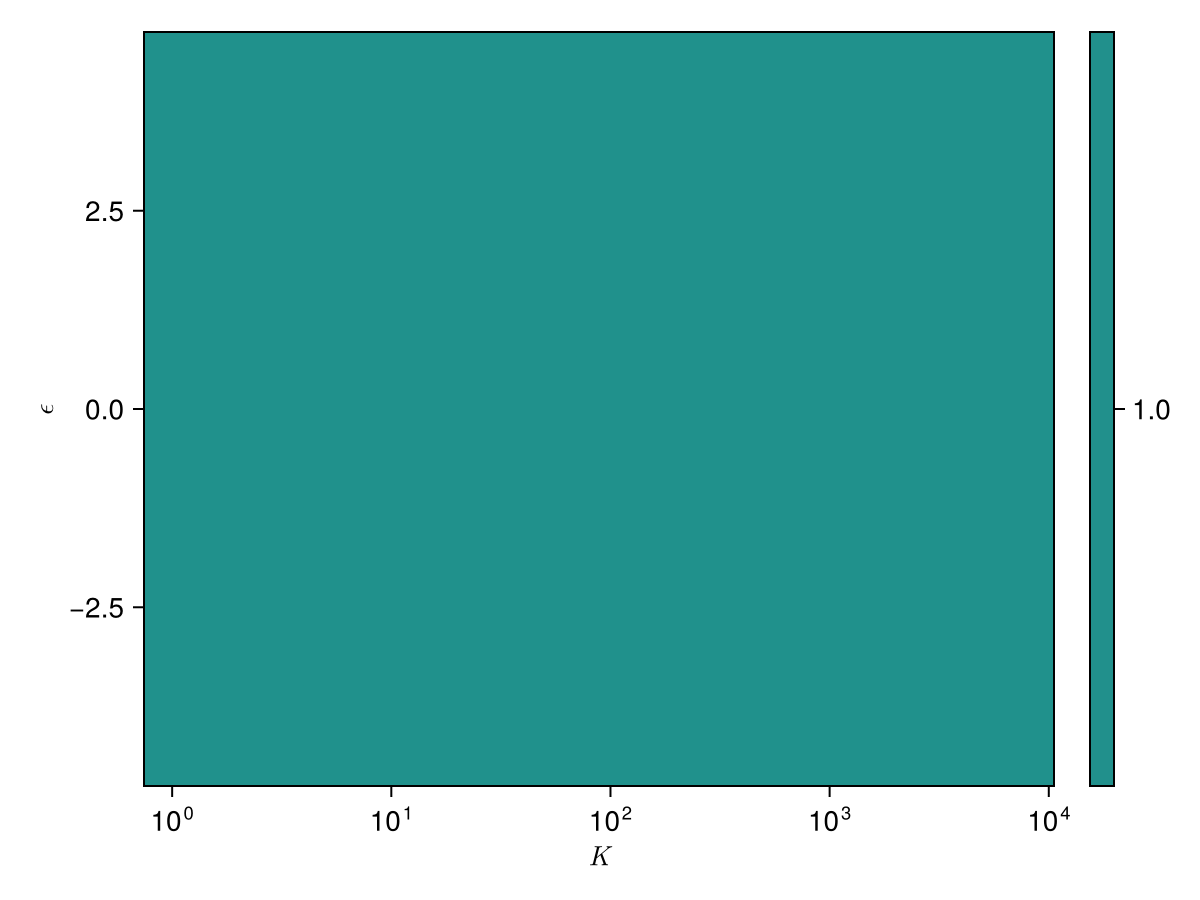

In [67]:
fig = Figure()
ax = make_hm_ax(fig[1,1])
hm = heatmap!(ax, 10 .^ logKs, leak_xs, Int.(nospace_results.retcodes);
    colormap=Categorical(:viridis)
)
Colorbar(fig[1,2], hm)

fig

In [81]:
mmp = MMParams(;
    K=10^1.9,
    l=0.99,
    m=10.,
    c=1.,
    k=0.0,
    d=1.0,
)
ps = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(ps, copy([100., 0., 0.]), T)

tol = 1000 * eps()
@time s = solve(p, TRBDF2();
    abstol=tol,
    reltol=tol,
    callback=make_timer_callback(10),
);

  0.044416 seconds (72.75 k allocations: 6.429 MiB)


In [82]:
f = plot_mmicrm_sol(s)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

# Identifying spatial structure in PDE sol
Focus just on N as the others will reflect that

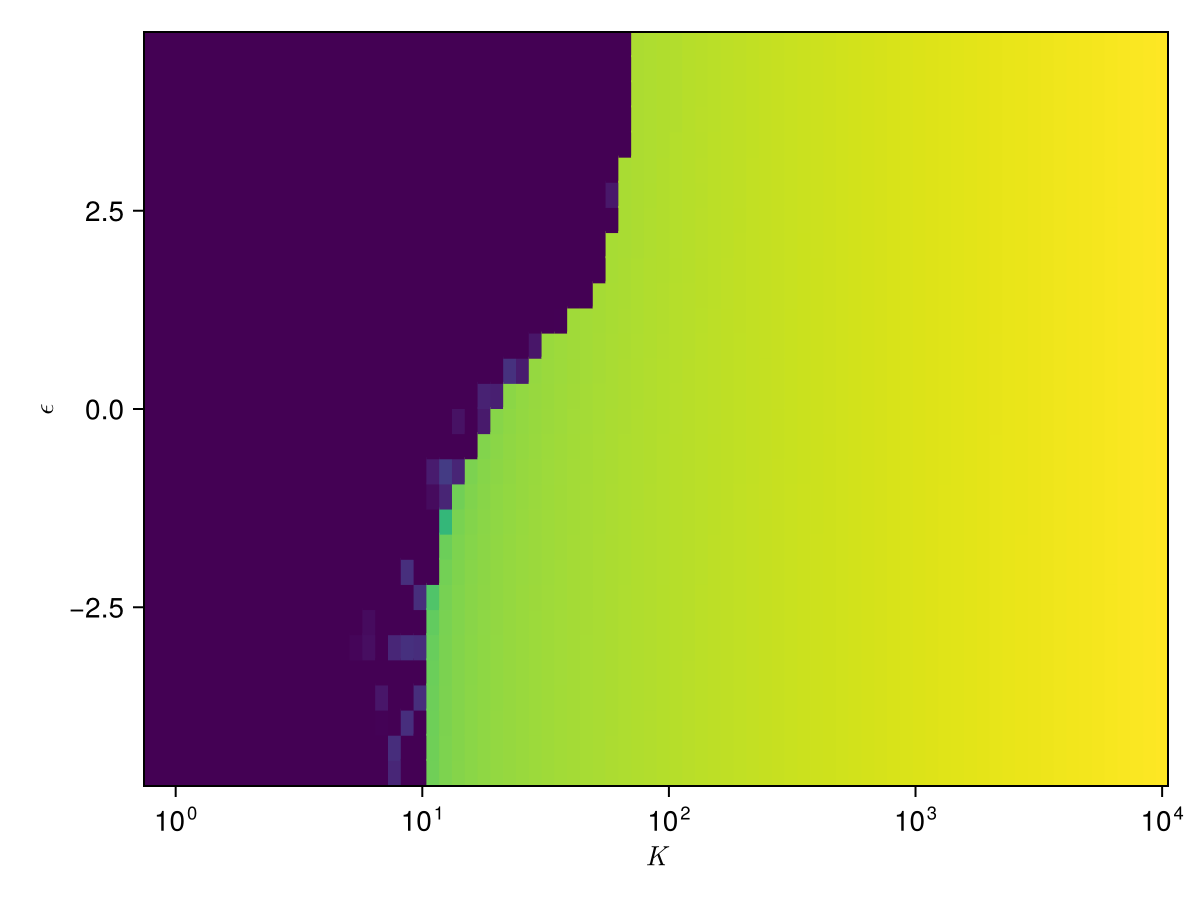

In [10]:
fs_N = map(fss) do fs
    fs[1,:]
end;
fs_mN = mean.(fs_N)

fig = Figure()
ax = make_hm_ax(fig[1,1])
heatmap!(ax, 10 .^ logKs, leak_xs, clamp_for_log(fs_mN);
    colorscale=log10
)
fig

In [9]:
using Peaks

# Basics

In [91]:
ext_ls = extrema(ls)
exticks = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], 7))

([4.595119850134589, 1.5621850275835547, 0.678184307883233, -0.0, -0.6781843078832329, -1.5621850275835547, -4.595119850134589], ["0.01", "0.17", "0.34", "0.50", "0.66", "0.83", "0.99"])

In [92]:
fs_N = map(fss) do fs
    mean(fs[1,:])
end;
fs_N_ext = map(fss) do fs
    ex = extrema(fs[1,:])
    ex[2] - ex[1]
end;

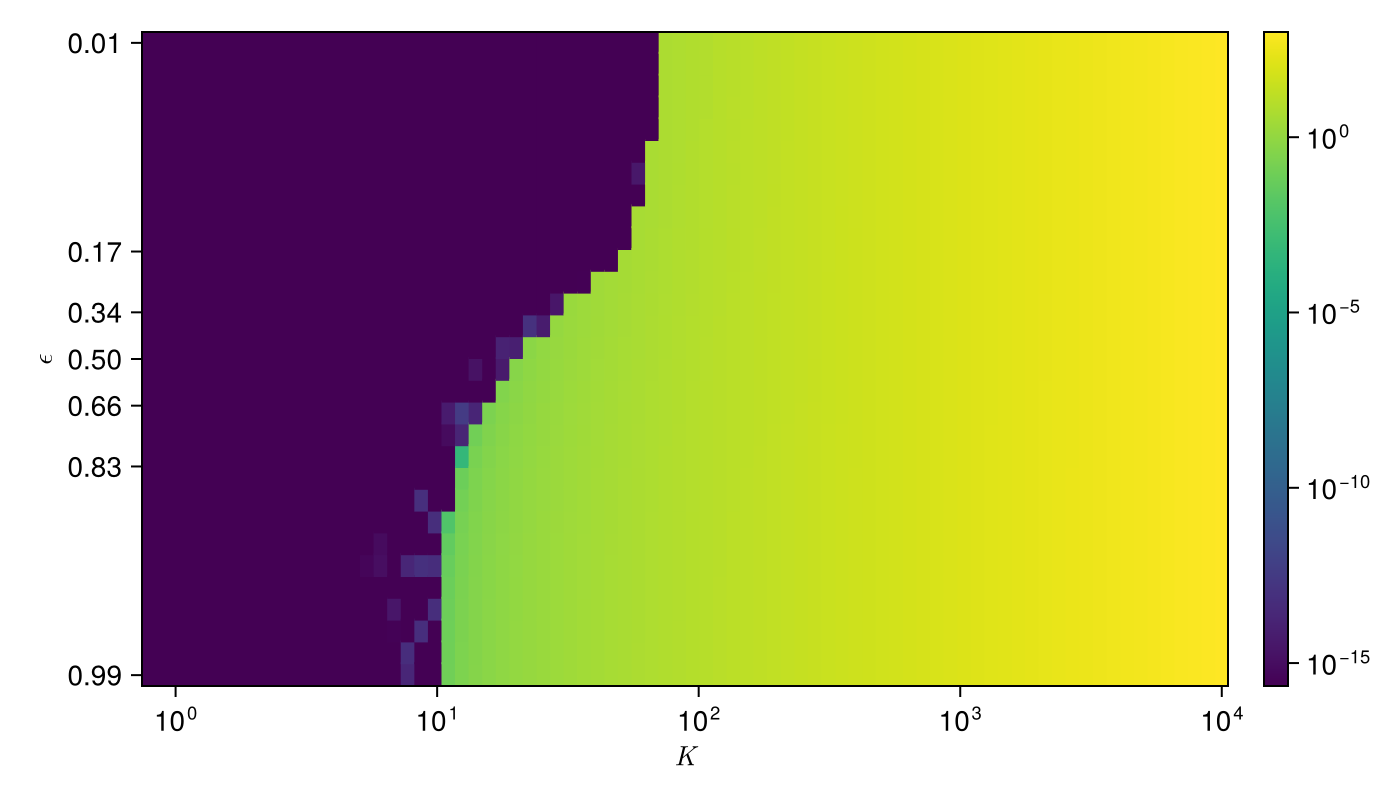

In [101]:
fig = Figure(; size=(700, 400))
ax = make_hm_ax(fig[1,1]; yticks=exticks)
hm = heatmap!(ax, 10 .^ logKs, leak_xs, clamp_for_log(fs_N);
    colorscale=log10
)
Colorbar(fig[1,2], hm)
fig

In [102]:
wsNs = clamp_for_log(fs_N)
nsNs = clamp_for_log(getindex.(nsfss, 1))
dNs = wsNs .- nsNs
ext = extrema(vcat(wsNs, nsNs))

(2.220446049250313e-16, 998.9899998999981)

In [121]:
function draw_extline!(ax, ls;
    m=1.,
    c=1.,
    kwargs...
)
    r = 1.
    line_Ks = map(ls) do l
        if l > 0.5
            4 * l * m * r / c
        else
            m * r / (c * (1 - l))
        end
    end
    
    lines!(ax, line_Ks, LeakageScale.ltox.(ls);
        # color=PaperColors.mm_extline(),
        # linewidth=1.,
        kwargs...
    )

    ax
end
function draw_fr_instab_line!(ax, ls;
    m=1.,
    c=1.,
    kwargs...
)
    r = 1.
    line_Ks = map(ls) do l
        if l > 0.5
            m * r / (c * (1 - l))
        else
            missing
        end
    end
    
    lines!(ax, line_Ks, LeakageScale.ltox.(ls);
        # color=PaperColors.mm_extline(),
        # linewidth=1.,
        kwargs...
    )

    ax
end

draw_fr_instab_line! (generic function with 1 method)

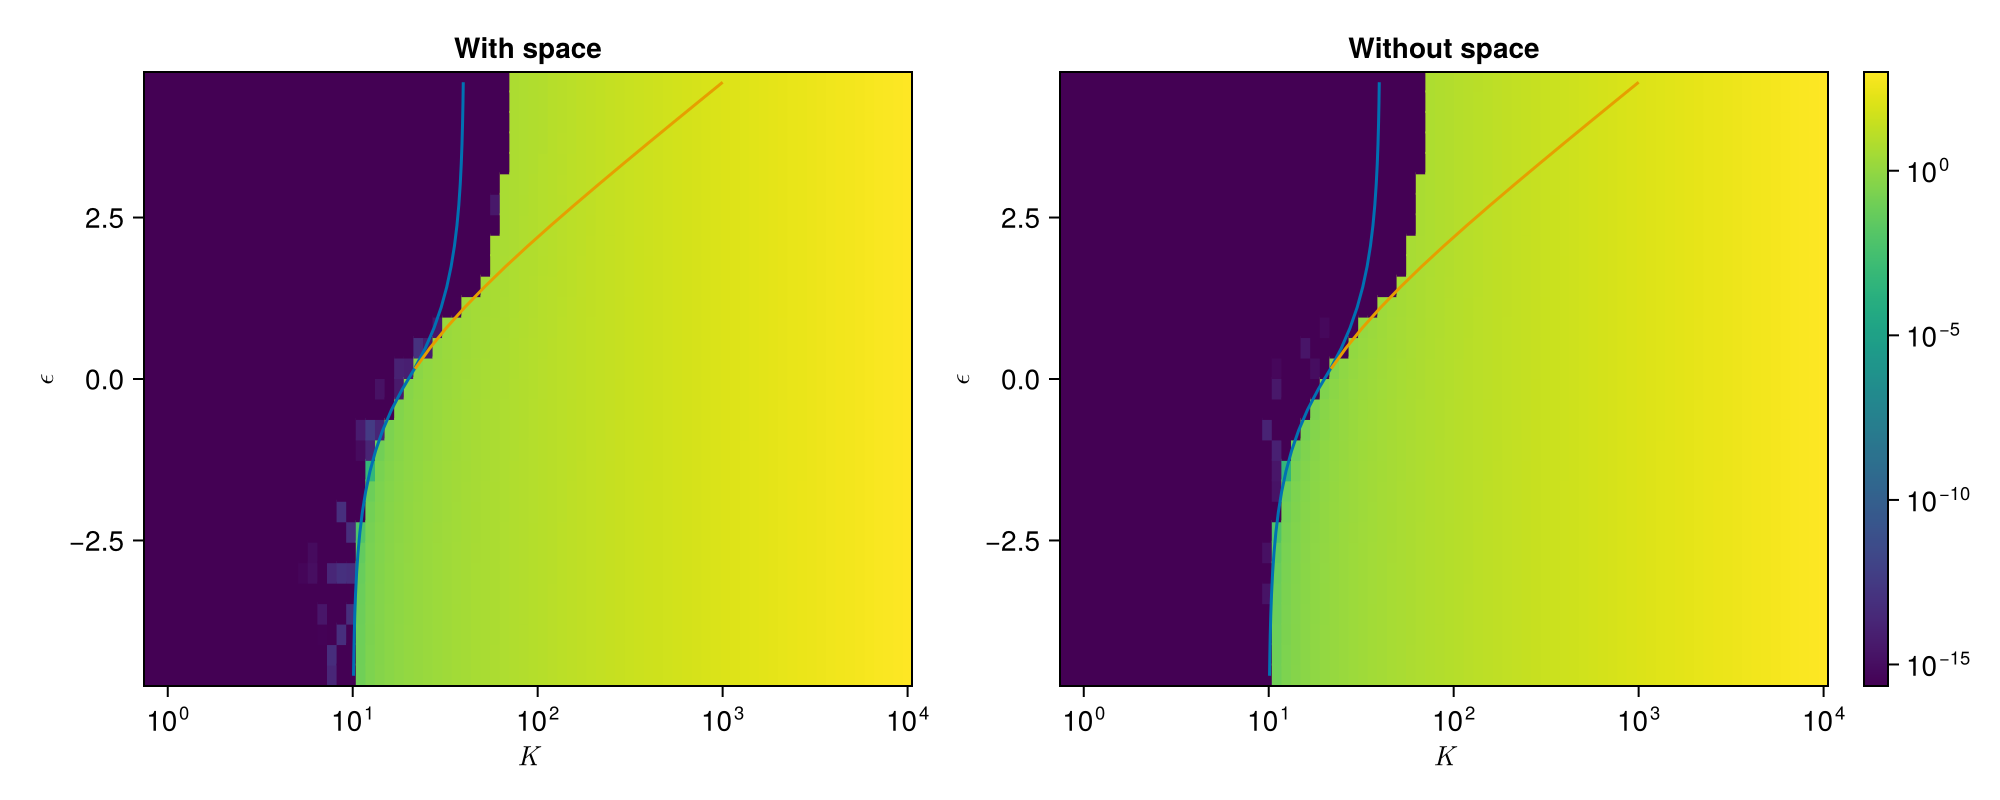

In [123]:
fig = Figure(; size=(1000, 400))
ax1 = make_hm_ax(fig[1,1]; title="With space")
ax2 = make_hm_ax(fig[1,2]; title="Without space")

hm1 = heatmap!(ax1, 10 .^ logKs, leak_xs, wsNs;
    colorscale=log10,
    colorrange=ext
)
hm2 = heatmap!(ax2, 10 .^ logKs, leak_xs, nsNs;
    colorscale=log10,
    colorrange=ext
)

for ax in [ax1, ax2]
    draw_extline!(ax, ls; m=f["m"])
    draw_fr_instab_line!(ax, ls; m=f["m"])
end

Colorbar(fig[1,3], hm1)
fig

In [103]:
fig = Figure()
ax = make_hm_ax(fig[1,1])

hm = heatmap!(ax, 10 .^ logKs, leak_xs, dNs)

Colorbar(fig[1,2], hm)

fig

# Running a single system

In [264]:
L = 5 # system size in non-dim units
sN = 5000 # number of spatial points
epsilon = 1e-5 # initial condition noise amplitude

dx = L / (sN + 1)
u0 = clamp.(reduce(hcat, [[100.0, 0.0, 0.0] .+ epsilon .* randn(3) for _ in 1:sN]), 0.0, Inf)

mmp = MMParams(;
    K=10. ^ 2.3,
    m=10.0,
    l=1.0 - 0.17,
    k=0.0,
    c=1.0,
    d=1.0,
)
sps = BSMMiCRMParams(
    mmp_to_mmicrm(mmp; static=false),
    [1e-6, 1.0, 0.1],
    make_cartesianspace_smart(1; dx),
    nthreads()
)
sp = make_smmicrm_problem(sps, copy(u0), 1e6)

tol = 100000 * eps()
@time s = solve(sp, QNDF();
    # dense=false,
    # save_everystep=false,
    abstol=tol,
    reltol=tol,
    callback=make_timer_callback(120)
);

102.516107 seconds (11.77 M allocations: 26.302 GiB, 34.75% gc time)


In [265]:
f = plot_1dsmmicrm_sol_interactive(s)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)